In [1]:
from rasterstats import zonal_stats
from multiprocessing import Pool
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point



In [4]:
df = pd.read_csv('/mnt/inca/tillage_index/data/LUCAS_lulc/004_vld_lucas.lulc.csv', low_memory=False)
for col in ['ndvi.p50', 'ndwi.p50', 'ndwi.p25', 'ndwi.p75', 'ndvi.p75', 'ndvi.p25']:
    df[col] = (df[col]-125)*0.008
    
label = pd.read_excel('/mnt/inca/tillage_index/data/LUCAS_lulc/C3_legends.xls')
lc = label.loc[label['var']=='lc1']
lc = lc.drop(columns=['Unnamed: 0','whereClause','var'])
lc_map = dict(zip(lc['code'].values,lc['label'].values))
lc_class_map = dict(zip(df.sort_values('lc1_class')['lc1_class'].unique(),['Artificial','Cropland','Woodland','Shrubland','Grassland','Bare land and \nlichens/moss','Water area','Wetland']))

lu =  label.loc[label['var']=='lu1']
lu = lu.drop(columns=['Unnamed: 0','whereClause','var'])

df['lc1_class_label'] = df['lc1_class'].map(lc_class_map)

### calculate and visualize the stats

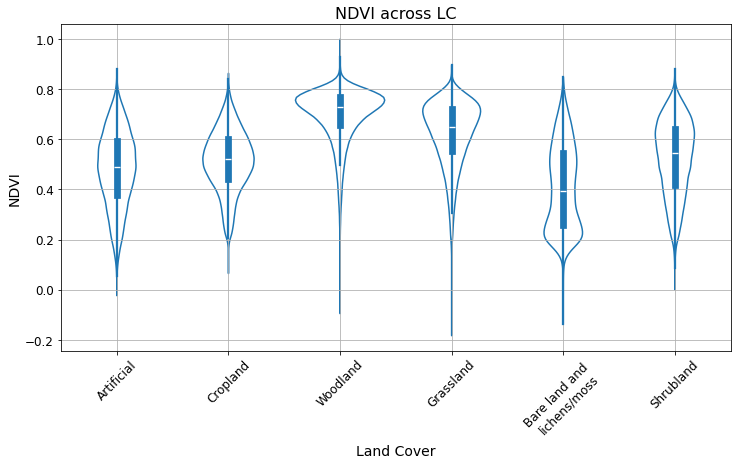

In [5]:
df_ndvi = df.loc[~df['lc1_class'].isin(['G','H'])]

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_ndvi, y='ndvi.p50', x='lc1_class_label', cut=0, fill=False)
plt.title('NDVI across LC', fontsize=16)
plt.xlabel('Land Cover', fontsize=14)
plt.ylabel('NDVI', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.grid()
plt.show()

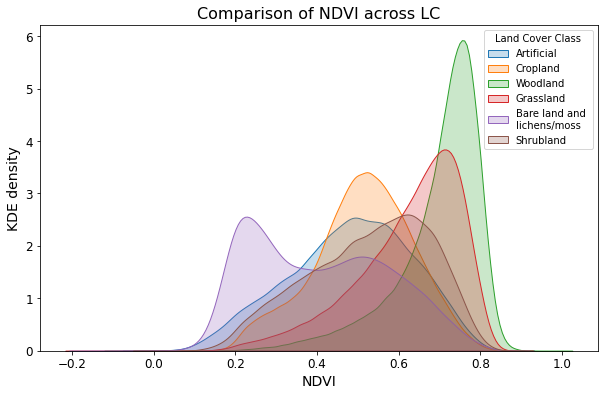

In [6]:
plt.figure(figsize=(10, 6))

# Plotting histograms for each category
for category in df['lc1_class_label'].unique()[0:-2]:
    subset = df[df['lc1_class_label'] == category]
    sns.kdeplot(subset['ndvi.p50'], label=category, fill=True)

plt.title('Comparison of NDVI across LC', fontsize=16)
plt.xlabel('NDVI', fontsize=14)
plt.ylabel('KDE density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Land Cover Class')
plt.show()

plt.figure(figsize=(10, 6))

# Plotting histograms for each category
for category in df['lc1_class_label'].unique()[0:-2]:
    subset = df[df['lc1_class_label'] == category]
    sns.kdeplot(subset['ndwi.p50'], label=category, fill=True)

plt.title('Comparison of NDWI across LC', fontsize=16)
plt.xlim([-0.6,0.3])
plt.xlabel('NDWI', fontsize=14)
plt.ylabel('KDE density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Land Cover Class')
plt.show()

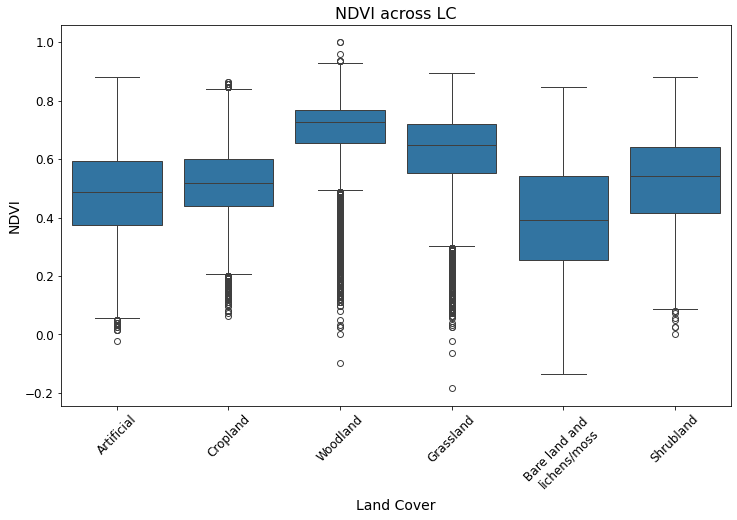

In [7]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_ndvi, x='lc1_class_label', y='ndvi.p50')
plt.title('NDVI across LC', fontsize=16)
plt.xlabel('Land Cover', fontsize=14)
plt.ylabel('NDVI', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

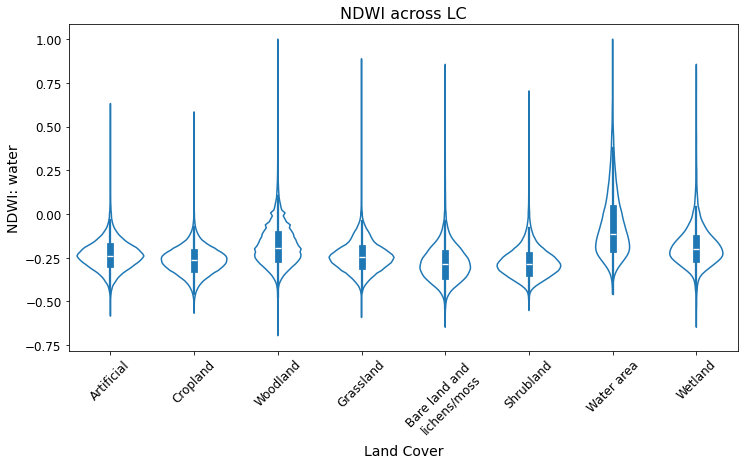

In [8]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, y='ndwi.p50', x='lc1_class_label', cut=0, fill=False)
plt.title('NDWI across LC', fontsize=16)
plt.xlabel('Land Cover', fontsize=14)
plt.ylabel('NDWI: water', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

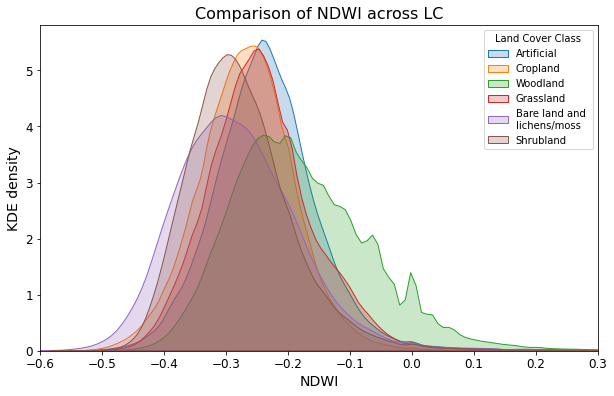

In [16]:
plt.figure(figsize=(10, 6))

# Plotting histograms for each category
for category in df['lc1_class_label'].unique()[0:-2]:
    subset = df[df['lc1_class_label'] == category]
    sns.kdeplot(subset['ndwi.p50'], label=category, fill=True)

plt.title('Comparison of NDWI across LC', fontsize=16)
plt.xlim([-0.6,0.3])
plt.xlabel('NDWI', fontsize=14)
plt.ylabel('KDE density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Land Cover Class')
plt.show()

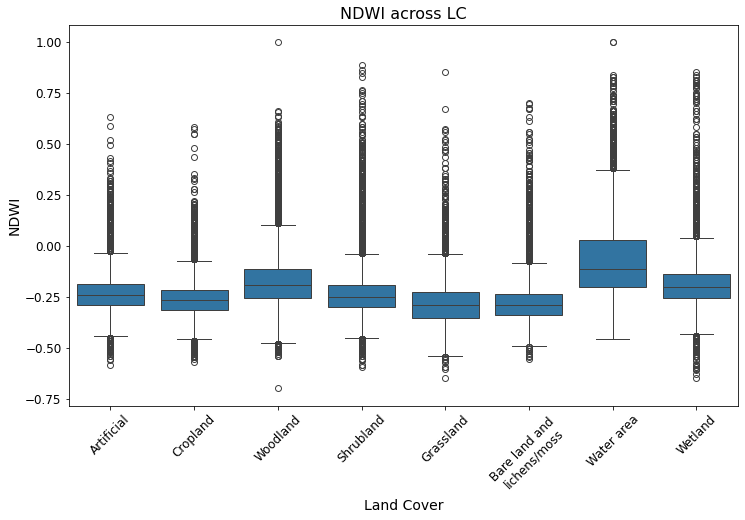

In [7]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df, x='lc1_class_label', y='ndwi.p50')
plt.title('NDWI across LC', fontsize=16)
plt.xlabel('Land Cover', fontsize=14)
plt.ylabel('NDWI', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

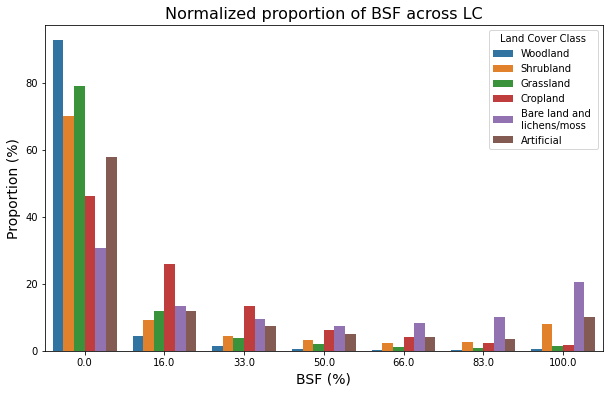

In [16]:

# Define your custom order
order = ['Woodland', 'Shrubland', 'Grassland', 'Cropland', 'Bare land and \nlichens/moss', 'Artificial']

# Ensure that 'lc1_class_label' is a categorical type with the specified order
df_ndvi.loc[:,'lc1_class_label'] = pd.Categorical(df_ndvi['lc1_class_label'], categories=order, ordered=True)

# Calculate the size for each group
group_size = df_ndvi.groupby(['lc1_class_label', 'bs']).size().reset_index(name='count')

# Calculate the total count for each 'lc1_class_label'
total_count = group_size.groupby('lc1_class_label')['count'].transform('sum')

# Calculate the proportion
group_size['proportion'] = 100 * group_size['count'] / total_count

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='bs', y='proportion', hue='lc1_class_label', data=group_size, hue_order=order)
# sns.lineplot(x='bs', y='proportion', hue='lc1_class_label', data=group_size, hue_order=order, style='lc1_class_label', markers=True, dashes=False)

plt.title('Normalized proportion of BSF across LC', fontsize=16)
plt.xlabel('BSF (%)', fontsize=14)
plt.ylabel('Proportion (%)', fontsize=14)
plt.legend(title='Land Cover Class')
plt.show()


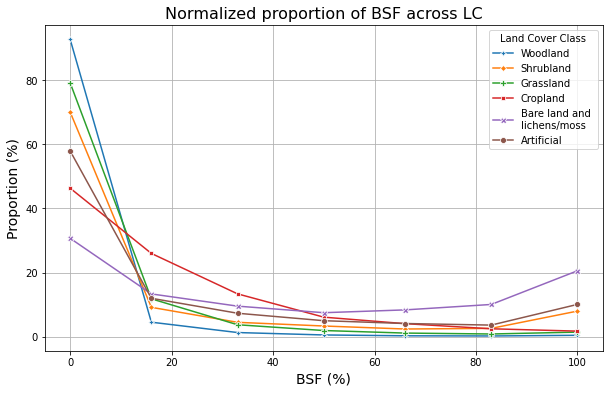

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='bs', y='proportion', hue='lc1_class_label', data=group_size, hue_order=order, style='lc1_class_label', markers=True, dashes=False)

plt.title('Normalized proportion of BSF across LC', fontsize=16)
plt.xlabel('BSF (%)', fontsize=14)
plt.ylabel('Proportion (%)', fontsize=14)
plt.legend(title='Land Cover Class')
plt.grid()
plt.show()

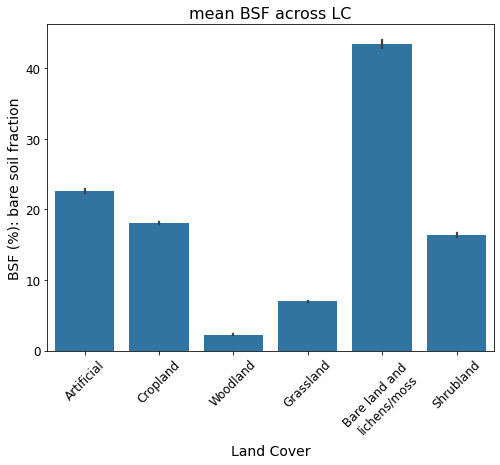

In [22]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.barplot(data=df_ndvi, y='bs', x='lc1_class_label')
plt.title('mean BSF across LC', fontsize=16)
plt.xlabel('Land Cover', fontsize=14)
plt.ylabel('BSF (%): bare soil fraction', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### crop specific

In [102]:
df_crop = df.loc[(df['lc1_class']=='B') & (df['lu1']=='U111')]
df_flevo = df_crop.loc[df['nuts2']=='NL23']

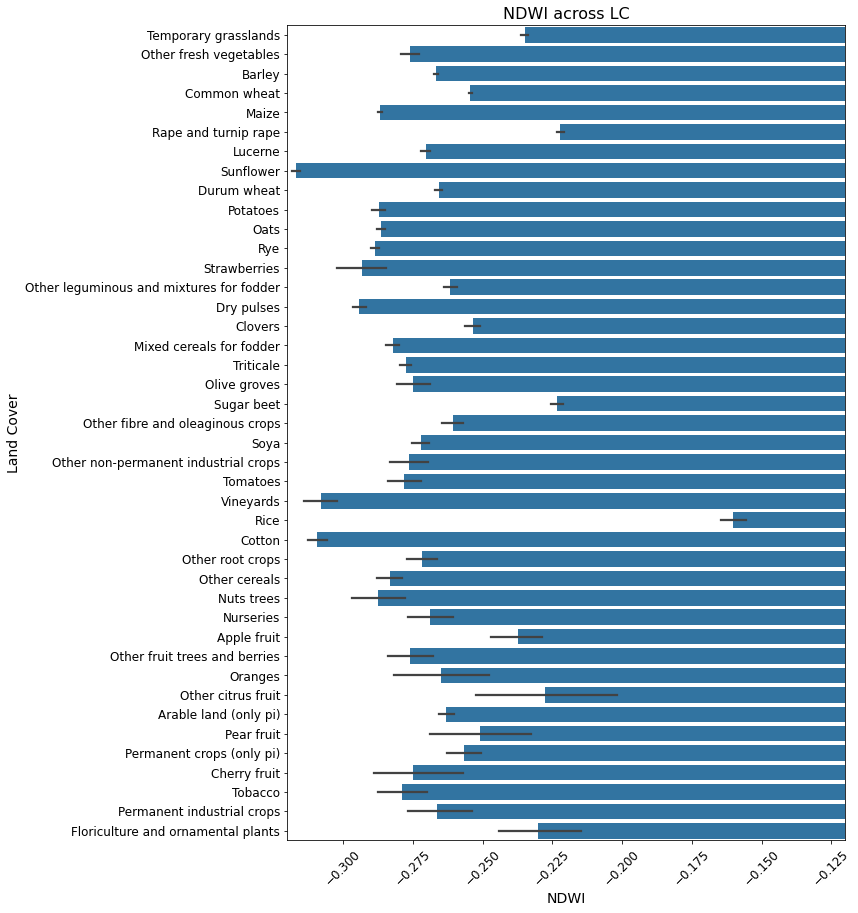

In [69]:
plt.figure(figsize=(10, 15))
sns.barplot(data=df_crop, y='lc1_label', x='ndwi.p50') 
plt.title('NDWI across LC', fontsize=16)
plt.ylabel('Land Cover', fontsize=14)
plt.xlabel('NDWI', fontsize=14)
plt.xlim([-0.32,-0.12])
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
### Flevoland examples, crop types

In [154]:
flevoland_sample = df_flevo_key.sort_values('gps_lat').loc[df_flevo_key['year']==2018][['nos','csr','bs','lc1_label','year','gps_lat','gps_long','point_id']]

from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(flevoland_sample['gps_long'], flevoland_sample['gps_lat'])]
flevoland_sample = gpd.GeoDataFrame(flevoland_sample, geometry=geometry, crs='4326')
flevoland_sample = flevoland_sample.to_crs('epsg:3035')
flevoland_sample = flevoland_sample.loc[flevoland_sample['csr']>0]

flevoland_point = flevoland_sample.iloc[[19,21,22,31]]
flevoland_sample.to_file(f'/mnt/inca/tillage_index/validate_data/LUCAS_lulc/002_tmp_flevoland.eg.gpkg',driver='GPKG')
flevoland_point.to_file(f'/mnt/inca/tillage_index/validate_data/LUCAS_lulc/005_vld_flevoland.point.gpkg',driver='GPKG')

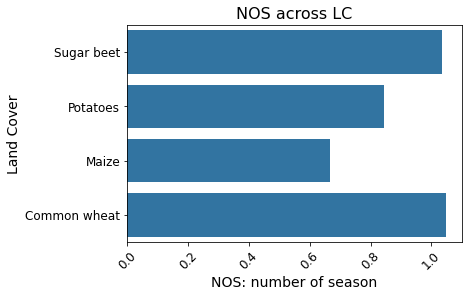

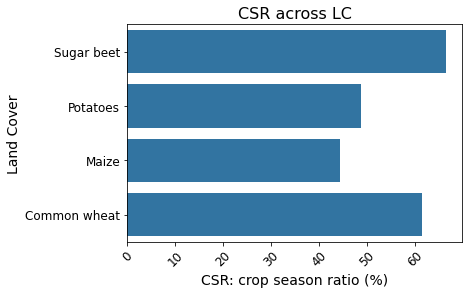

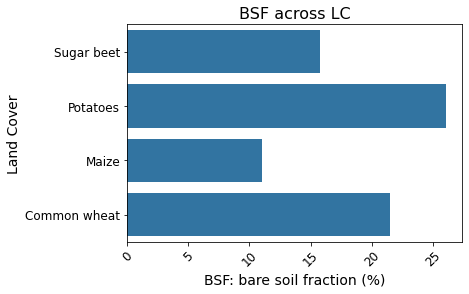

In [138]:
df_flevo_key = df_flevo.loc[df_flevo['lc1_label'].isin(['Common wheat', 'Maize', 'Potatoes', 'Sugar beet'])]

plt.figure(figsize=(6, 4))
sns.barplot(data=df_flevo_key, y='lc1_label', x='nos', estimator='mean', errorbar=None) 
plt.title('NOS across LC', fontsize=16)
plt.ylabel('Land Cover', fontsize=14)
plt.xlabel('NOS: number of season', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(data=df_flevo_key, y='lc1_label', x='csr', estimator='mean', errorbar=None) 
plt.title('CSR across LC', fontsize=16)
plt.ylabel('Land Cover', fontsize=14)
plt.xlabel('CSR: crop season ratio (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(data=df_flevo_key, y='lc1_label', x='bs', estimator='mean', errorbar=None) 
plt.title('BSF across LC', fontsize=16)
plt.ylabel('Land Cover', fontsize=14)
plt.xlabel('BSF: bare soil fraction (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

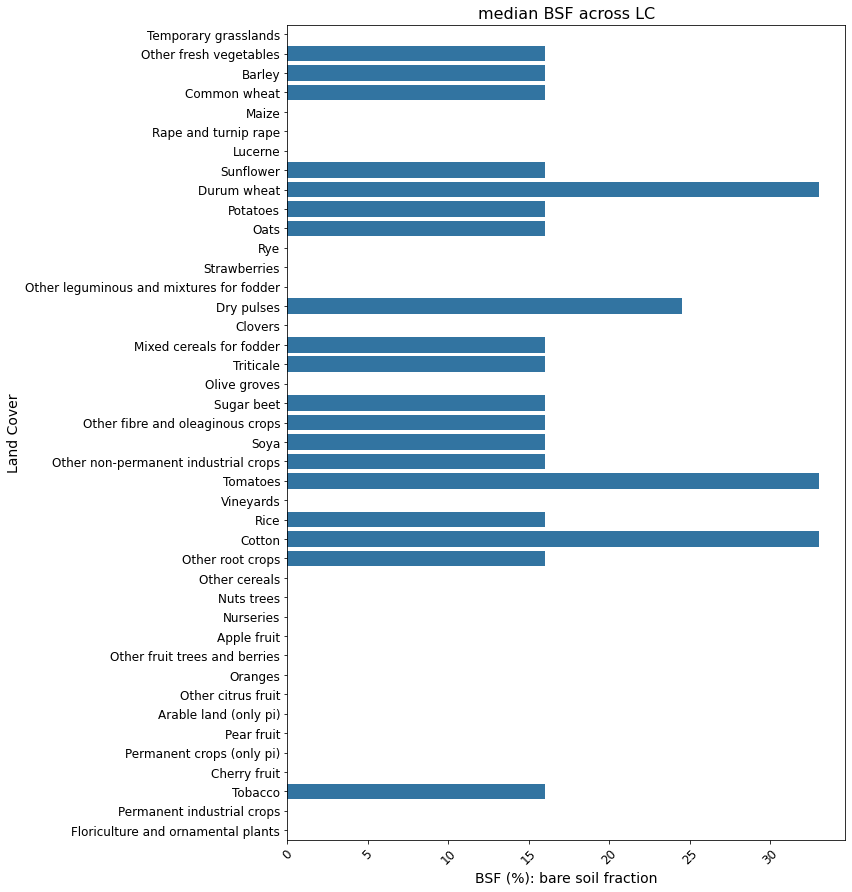

In [79]:
plt.figure(figsize=(10, 15))
sns.barplot(data=df_crop, y='lc1_label', x='bs', estimator='median', errorbar=None) 
plt.title('median BSF across LC', fontsize=16)
plt.ylabel('Land Cover', fontsize=14)
plt.xlabel('BSF (%): bare soil fraction', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [84]:
dff_crop = df_crop.loc[df_crop['lc1'].isin(['B11','B13','B16','B17','B21','B22','B31','B34','B42','B71','B73','B82','B84'])]

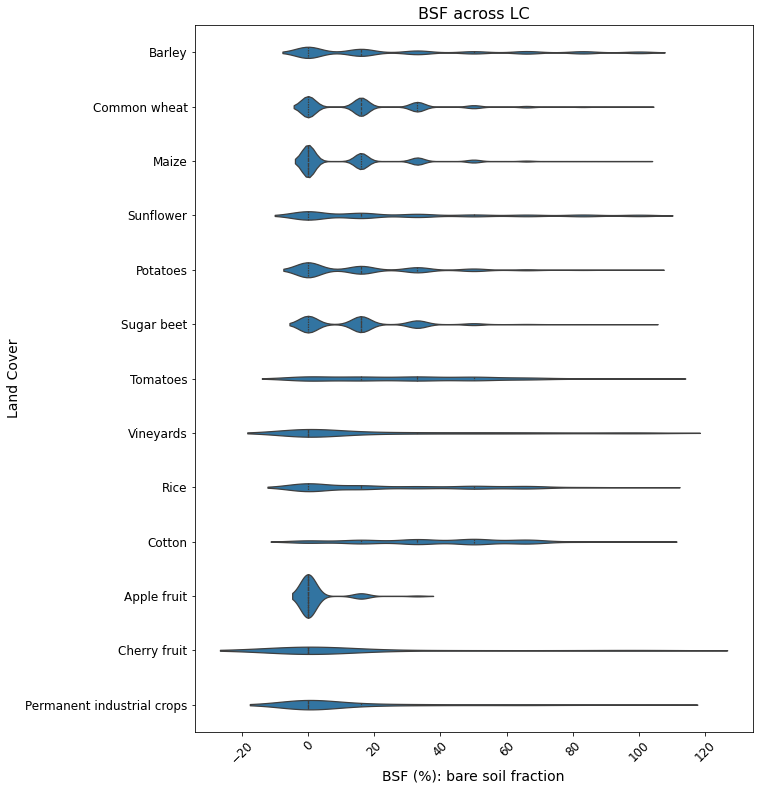

In [91]:
plt.figure(figsize=(10, 13))
sns.violinplot(data=dff_crop, y='lc1_label', x='bs',inner='quart', density_norm='area') 
plt.title('BSF across LC', fontsize=16)
plt.ylabel('Land Cover', fontsize=14)
plt.xlabel('BSF (%): bare soil fraction', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

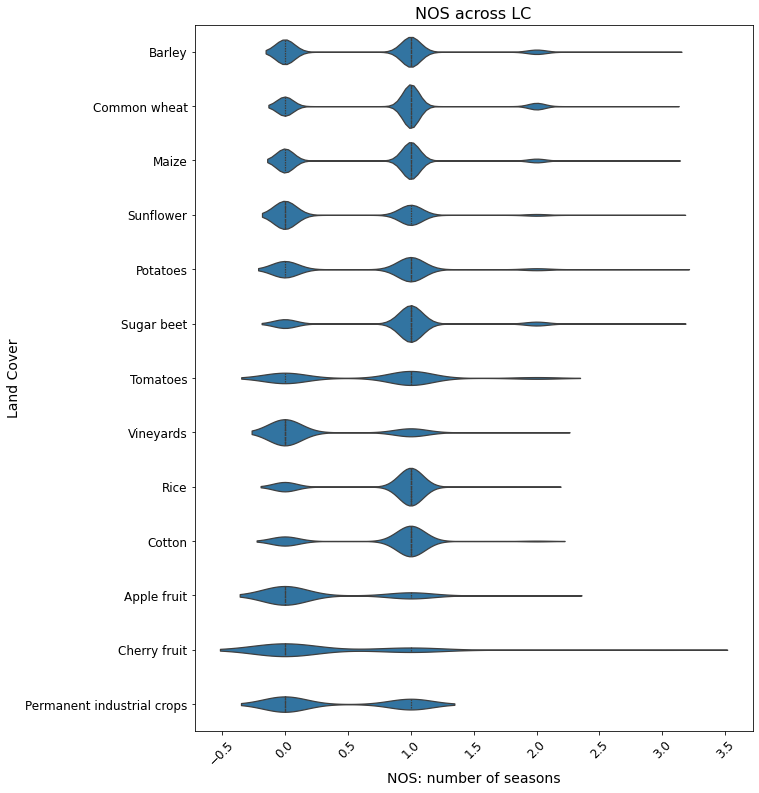

In [90]:
plt.figure(figsize=(10, 13))
sns.violinplot(data=dff_crop, y='lc1_label', x='nos',inner='quart', density_norm="area") 
plt.title('NOS across LC', fontsize=16)
plt.ylabel('Land Cover', fontsize=14)
plt.xlabel('NOS: number of seasons', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### temporal change

In [6]:
# with obvious bs trend, and only 2 lc classes in the time series

kl = []
geometry = [Point(xy) for xy in zip(df['gps_long'], df['gps_lat'])]
df = gpd.GeoDataFrame(df, geometry=geometry, crs='4326')
df = df.to_crs('epsg:3035')

# dfc_trend = df.loc[df['trend-bs.p50'].abs()>50]

# for i in dfc_trend['point_id'].unique():
#     temp = dfc_trend.loc[dfc_trend['point_id']==i]
#     if (len(temp)>3) & (len(temp['lc1'].unique())==2) & (len(temp['trend-ndvi.p50'].unique())==1):
#         kl.append(i)

# dfc_trend = dfc_trend.loc[dfc_trend['point_id'].isin(kl)]
# dfc_trend.to_file(f'/mnt/inca/tillage_index/validate_data/LUCAS_lulc/004_tmp_trend.all.gpkg',driver='GPKG')


In [256]:
# rice drying trend

kl = []
dfc_rice = df.loc[df['lc1']=='B17']

for i in dfc_rice['point_id'].unique():
    temp = dfc_rice.loc[dfc_rice['point_id']==i]
    if (len(temp)>3) & (len(temp['trend-ndvi.p50'].unique())==1):
        kl.append(i)

dfc_rice = dfc_rice.loc[dfc_rice['point_id'].isin(kl)]
dfc_rice.to_file(f'/mnt/inca/tillage_index/validate_data/LUCAS_lulc/005_tmp_rice.all.gpkg',driver='GPKG')

In [5]:
# change_id = [42122470, 38363000, 49923058, 46284626, 34883454, 31721858, 53481908]
# change_id = [38363000, 42122470, 49923058, 31721858]
change_id = [38363000, 42122470, 49923058]

dfc = df.loc[df['point_id'].isin(change_id)]
# dfc.to_file(f'/mnt/inca/tillage_index/validate_data/LUCAS_lulc/003_tmp_trend.eg.gpkg',driver='GPKG')

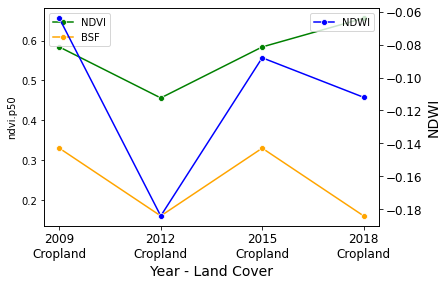

38363000 FRE2
['Sugar beet', 'Common wheat', 'Sugar beet', 'Common wheat']
['Agriculture (excluding fallow land and kitchen gardens)', 'Agriculture (excluding fallow land and kitchen gardens)', 'Agriculture (excluding fallow land and kitchen gardens)', 'Agriculture (excluding fallow land and kitchen gardens)']


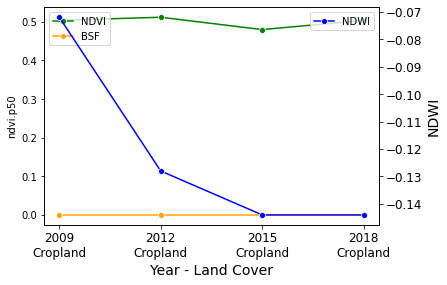

42122470 ITC4
['Rice', 'Rice', 'Rice', 'Rice']
['Agriculture (excluding fallow land and kitchen gardens)', 'Agriculture (excluding fallow land and kitchen gardens)', 'Agriculture (excluding fallow land and kitchen gardens)', 'Agriculture (excluding fallow land and kitchen gardens)']


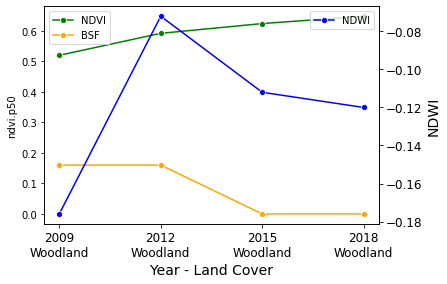

49923058 PL21
['Coniferous woodland', 'Pine dominated coniferous woodland', 'Pine dominated coniferous woodland', 'Pine dominated coniferous woodland']
['Forestry', 'Forestry', 'Forestry', 'Forestry']


In [6]:
import warnings
warnings.filterwarnings('ignore')

def plot_change(idd):
    temp = df.loc[df['point_id']==idd]
#     if temp.iloc[0]['nuts2'] not in ['SE31', 'SE33', 'SE32', 'SE12']:
#         return
#     if 'A' not in temp['lc1_class'].unique().tolist():
#         return
    temp.loc[:,'combined_label'] = temp['year'].astype(str) + "\n" + temp['lc1_class_label']
    temp['bs'] = temp['bs']/100
    
    plt.figure(figsize=(6, 4))
# #     sns.barplot(data=temp, y='ndvi.p50', x='combined_label') 
#     sns.lineplot(data=temp, y='ndvi.p50', x='combined_label', marker='o', dashes=False, label='NDVI') #, color='green'
#     sns.lineplot(data=temp, y='ndwi.p50', x='combined_label', marker='o', dashes=False, label='NDWI') 
#     sns.lineplot(data=temp, y='bs', x='combined_label', marker='o', dashes=False, label='BSF')
#     plt.title('NDVI across time', fontsize=16)
#     plt.ylabel('NDVI', fontsize=14)
#     plt.xlabel('year - land cover', fontsize=14)
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)
#     plt.legend()
#     plt.show()
    
    ax1 = sns.lineplot(data=temp, y='ndvi.p50', x='combined_label', marker='o', color='green', label='NDVI')
    sns.lineplot(data=temp, y='bs', x='combined_label', marker='o', color='orange', dashes=False, label='BSF')
#     plt.ylabel('NDVI', fontsize=14)
#     plt.title('NDVI and NDWI across time', fontsize=16)
    plt.xlabel('Year - Land Cover', fontsize=14)
    plt.xticks(fontsize=12)
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    sns.lineplot(data=temp, y='ndwi.p50', x='combined_label', marker='o', color='blue', label='NDWI', ax=ax2)
    plt.ylabel('NDWI', fontsize=14)
    ax2.legend(loc='upper right')
    plt.yticks(fontsize=12)
    plt.show()

    print(temp.iloc[0]['point_id'], temp.iloc[0]['nuts2'])
    print(temp['lc1_label'].values.tolist())
    print(temp['lu1_label'].values.tolist())

    
for iii in change_id:
    plot_change(iii)
# temp[['year', 'nuts2', 'gps_lat', 'gps_long', 'lc1', 'lc1_label',
#        'lu1', 'lu1_label','lc1_class', 'lc1_class_label']]

In [11]:
geometry = [Point(xy) for xy in zip(dfc['gps_long'], dfc['gps_lat'])]
gdf = gpd.GeoDataFrame(dfc, geometry=geometry, crs='4326')
gdf.to_file('/mnt/inca/tillage_index/data/010_vld_trend.gpkg',driver = 'GPKG')

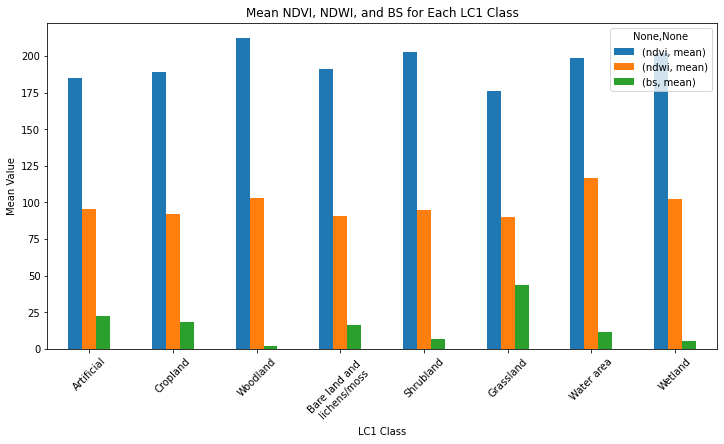

In [93]:
class_mean = gdf.groupby('lc1_class')[['ndvi', 'ndwi', 'bs']].agg(['mean'])
class_mean.index = class_mean.index.map(class_map)

class_mean.plot(kind='bar', figsize=(12, 6), ylabel='Mean Value')
plt.title('Mean NDVI, NDWI, and BS for Each LC1 Class')
plt.xlabel('LC1 Class')
plt.xticks(rotation=45)
plt.show()

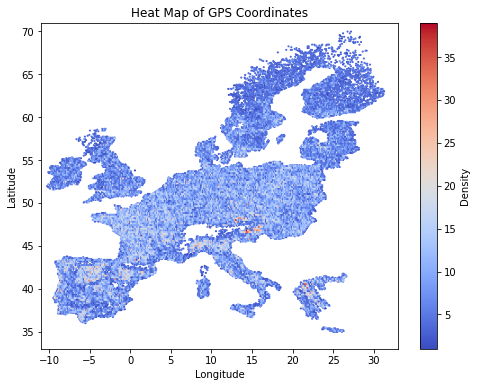

In [40]:

plt.figure(figsize=(8, 6))
plt.hexbin(dfc['gps_long'], dfc['gps_lat'], gridsize=300, cmap='coolwarm', mincnt=1)
plt.colorbar(label='Density')
plt.ylim([33,71])
plt.xlim([-11,33])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heat Map of GPS Coordinates')
plt.show()

### organize the points and overlay with layers

In [2]:
# df = pd.read_csv('/mnt/inca/tillage_index/validate_data/LUCAS_lulc/lucas_harmo_uf.csv', low_memory=False)
# df.loc[df['th_long']<0,'gps_long'] = df.loc[df['th_long']<0,'gps_long']*(-1)
# pnt = gpd.read_file('/mnt/inca/tillage_index/validate_data/LUCAS_lulc/LUCAS_gps_geom.shp')

# df = df.loc[df['gps_lat']<80]
# df = df.loc[df['gps_long']<80]
# df = df.loc[df['lc2']=='8']
# df = df.dropna(subset=['year','gps_lat','th_lat','gps_long','th_long','lc1','lc1_label','lu1','lu1_label']).reset_index()
# df = df[['point_id','year','nuts2','gps_lat','gps_long','lc1','lc1_label','lu1','lu1_label','survey_date','crop_residues','revisit']]

# from shapely.geometry import Point

# geometry = [Point(xy) for xy in zip(df['gps_long'], df['gps_lat'])]
# gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='4326')
# gdf = gdf.to_crs('epsg:3035')

# # gdf.to_file(f'/mnt/inca/tillage_index/validate_data/LUCAS_lulc/001_tmp_lulc.overlay.gpkg',driver='GPKG')

# from eumap.misc import find_files, nan_percentile, GoogleSheet
# from eumap.raster import read_rasters, save_rasters
# from eumap.mapper import SpaceOverlay


# with open('/mnt/inca/tillage_index/validate_data/LUCAS_lulc/layers.txt', 'r') as file:
#     lines = file.readlines()
# layers = [line.strip() for line in lines]

# for i in layers:
#     print(i)

# # overlay with annual covariates first
# from pathlib import Path
# year = gdf['year'].unique().tolist()
# year.sort()
# year = [int(y) for y in year]

# names = ['ndvi.p25','ndwi.p25', 'ndvi.p75', 'ndwi.p75','bs','csr','ndvi.p50','ndwi.p50','nos','trend-ndvi.p50','trend-bs.p50']

# for y in year:
#     tmp_gpkg = f'/mnt/inca/tillage_index/validate_data/LUCAS_lulc/001_tmp_lulc.overlay.{y}.gpkg'
    
#     dfy = gdf.loc[gdf['year']==y]
#     dfy.to_file(tmp_gpkg, driver='GPKG')
    
#     files = [i.replace('{year}',str(y)) for i in layers]
#     fnames = [i.split('/')[-1][0:-4] for i in files]
#     name_map = dict(zip(fnames,names))
#     files = [Path(i) for i in files]

#     dfo = SpaceOverlay(tmp_gpkg, fn_layers=files, max_workers=50, verbose=False)
#     dft = dfo.run()
#     dft = dft.rename(columns=name_map)
#     dft.to_csv(f'/mnt/inca/tillage_index/validate_data/LUCAS_lulc/001_tmp_lulc.overlay.{y}.csv', index=False)
    
# gdf = []
# for y in year:
#     temp = pd.read_csv(f'/mnt/inca/tillage_index/validate_data/LUCAS_lulc/001_tmp_lulc.overlay.{y}.csv', low_memory=False)
#     gdf.append(temp)
    
# gdf = pd.concat(gdf)
# gdf = gdf.drop(columns=['overlay_id','geometry'])

# gdf = gdf.loc[gdf['lc1']!='8']
# gdf['lc1_class'] = gdf['lc1'].astype(str).str[0]

# # # df = pd.read_csv('/mnt/inca/tillage_index/validate_data/LUCAS_lulc/004_vld_lucas.lulc.csv', low_memory=False)
# # gdf = gdf.drop(columns=['nuts2', 'lc1_label', 'lu1_label','crop_residues','lc1_class'])
# # df = df.merge(gdf,how='inner',on=['year','gps_lat','gps_long','lc1','lu1','survey_date'])

# gdf = gdf.dropna(subset=['nos', 'bs', 'trend-bs.p50', 'csr', 'trend-ndvi.p50', 'ndvi.p50', 'ndwi.p50', 'ndwi.p25', 'ndwi.p75', 'ndvi.p75', 'ndvi.p25'])
# gdf.to_csv(f'/mnt/inca/tillage_index/validate_data/LUCAS_lulc/004_vld_lucas.lulc.csv', index=False)

http://192.168.1.30:8333/ai4sh/ndvi/ndvi_glad.landsat.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127.tif
http://192.168.1.30:8333/ai4sh/ndwi/ndwi_glad.landsat.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127.tif
http://192.168.1.30:8333/ai4sh/ndvi/ndvi_glad.landsat.seasconv.m.yearly_p75_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127.tif
http://192.168.1.30:8333/ai4sh/ndwi/ndwi_glad.landsat.seasconv.m.yearly_p75_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127.tif
http://192.168.1.30:8333/ai4sh/bs/bs_glad.landsat.seasconv.m.yearly_sum_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127.tif
http://192.168.1.30:8333/ai4sh/cdr/cdr_glad.landsat.seasconv_m_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127.tif
http://192.168.1.30:8333/ai4sh/ndvi/ndvi_glad.landsat.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127.tif
http://192.168.1.30:8333/ai4sh/ndwi/ndwi_glad.landsat.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1